**B.**

In this section, you will set up a Monte Carlo program for bosons in a **three-dimensional harmonic trap**.

**Download (copy-and-paste)** the below program markov_harmonic_bosons.py,

In [18]:
import random, math, numpy, sys, os

def levy_harmonic_path_3d(k):
    x0 = tuple([random.gauss(0.0, 1.0 / math.sqrt(2.0 *
                math.tanh(k * beta / 2.0))) for d in range(3)])
    x = [x0]
    for j in range(1, k):
        Upsilon_1 = 1.0 / math.tanh(beta) + 1.0 / \
                          math.tanh((k - j) * beta)
        Upsilon_2 = [x[j - 1][d] / math.sinh(beta) + x[0][d] /
                     math.sinh((k - j) * beta) for d in range(3)]
        x_mean = [Upsilon_2[d] / Upsilon_1 for d in range(3)]
        sigma = 1.0 / math.sqrt(Upsilon_1)
        dummy = [random.gauss(x_mean[d], sigma) for d in range(3)]
        x.append(tuple(dummy))
    return x

def rho_harm_3d(x, xp):
    Upsilon_1 = sum((x[d] + xp[d]) ** 2 / 4.0 *
                    math.tanh(beta / 2.0) for d in range(3))
    Upsilon_2 = sum((x[d] - xp[d]) ** 2 / 4.0 /
                    math.tanh(beta / 2.0) for d in range(3))
    return math.exp(- Upsilon_1 - Upsilon_2)

N = 64
T_star = 0.7
beta = 1.0 / (T_star * N ** (1.0 / 3.0))

# Initial condition
positions = {}
for k in range(N):
    a = levy_harmonic_path_3d(1)
    positions[a[0]] = a[0]
    
# Monte Carlo loop
nsteps = 10000
for step in range(nsteps):    
    # move 1: resample one permutation cycle
    boson_a = random.choice(list(positions.keys()))
    perm_cycle = []
    while True:
        perm_cycle.append(boson_a)
        boson_b = positions.pop(boson_a)
        if boson_b == perm_cycle[0]:
            break
        else:
            boson_a = boson_b
    k = len(perm_cycle)
    perm_cycle = levy_harmonic_path_3d(k)
    positions[perm_cycle[-1]] = perm_cycle[0]
    for k in range(len(perm_cycle) - 1):
        positions[perm_cycle[k]] = perm_cycle[k + 1]
    # move 2: exchange
    a_1 = random.choice(list(positions.keys()))
    b_1 = positions.pop(a_1)
    a_2 = random.choice(list(positions.keys()))
    b_2 = positions.pop(a_2)
    weight_new = rho_harm_3d(a_1, b_2) * rho_harm_3d(a_2, b_1)
    weight_old = rho_harm_3d(a_1, b_1) * rho_harm_3d(a_2, b_2)
    if random.uniform(0.0, 1.0) < weight_new / weight_old:
        positions[a_1] = b_2
        positions[a_2] = b_1
    else:
        positions[a_1] = b_1
        positions[a_2] = b_2
#for boson in positions.keys():
 #   print(boson, positions[boson])

**B1**

Modify the above program (markov_harmonic_bosons.py) so that  it reads the initial configuration from a file (if it exists) and writes  the final configuration onto a file. This is analogous to what was done  in homework **session 3**. The snippets for reading/writing a configuration  (which corresponds to reading/writing all the pairs of key/value in the  dictionary) are given below.


In [6]:
# snippet 1: read the configuration from a file (if possible)
filename = 'data_boson_configuration.txt'
positions = {}
if os.path.isfile(filename):
    f = open(filename, 'r')
    for line in f:
        a = line.split()
        positions[tuple([float(a[0]), float(a[1]), float(a[2])])] = \
               tuple([float(a[3]), float(a[4]), float(a[5])])
    f.close()
    if len(positions) != N:
        sys.exit('ERROR in the input file.')
    print('Starting from file', filename)
else:
    for k in range(N):
        a = levy_harmonic_path_3d(1)
        positions[a[0]] = a[0]
    print('Starting from a new configuration')

Starting from a new configuration


In [7]:
# snippet 2: write configuration on a file
f = open(filename, 'w')
for a in positions:
    b = positions[a]
    f.write(str(a[0]) + ' ' + str(a[1]) + ' ' + str(a[2]) + ' ' +
           str(b[0]) + ' ' + str(b[1]) + ' ' + str(b[2]) + '\n')
f.close()

After you implement this change in the program, run it several times, to  make sure that the reading/writing of the configuration works smoothly.  Then further modify the above program, so that it also shows a **3D plot  of the final configuration.** This can be done with the following code  snippet, in which every permutation cycle is shown with a different  color, depending on its length.

- Run this program (with **N=64** and **T_star=0.7**) a few times (always use the last configuration to start the new run), and **upload one single plot of the final configuration** you obtained.

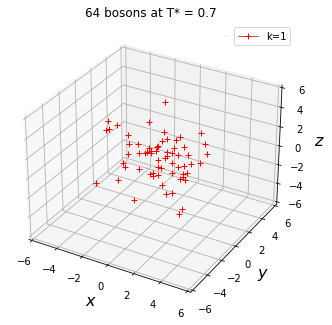

In [10]:
# snippet 3: Analyze cycles, do 3d plot
import pylab, mpl_toolkits.mplot3d

fig = pylab.figure()
ax = mpl_toolkits.mplot3d.axes3d.Axes3D(fig)
#ax.set_aspect('equal')
n_colors = 10
list_colors = pylab.cm.rainbow(numpy.linspace(0, 1, n_colors))[::-1]
dict_colors = {}
i_color = 0
positions_copy = positions.copy()
while positions_copy:
    x, y, z = [], [], []
    starting_boson = list(positions_copy)[0]
    boson_old = starting_boson
    while True:
        x.append(boson_old[0])
        y.append(boson_old[1])
        z.append(boson_old[2])
        boson_new = positions_copy.pop(boson_old)
        if boson_new == starting_boson: break
        else: boson_old = boson_new
    len_cycle = len(x)
    if len_cycle > 2:
        x.append(x[0])
        y.append(y[0])
        z.append(z[0])
    if len_cycle in dict_colors:
        color = dict_colors[len_cycle]
        ax.plot(x, y, z, '+-', c=color, lw=0.75)
    else:
        color = list_colors[i_color]
        i_color = (i_color + 1) % n_colors
        dict_colors[len_cycle] = color
        ax.plot(x, y, z, '+-', c=color, label='k=%i' % len_cycle, lw=0.75)
pylab.title(str(N) + ' bosons at T* = ' + str(T_star))
pylab.legend()
ax.set_xlabel('$x$', fontsize=16)
ax.set_ylabel('$y$', fontsize=16)
ax.set_zlabel('$z$', fontsize=16)
xmax = 6.0
ax.set_xlim3d([-xmax, xmax])
ax.set_ylim3d([-xmax, xmax])
ax.set_zlim3d([-xmax, xmax])
#pylab.savefig('plot_boson_configuration.png')
pylab.show()

**B1 (continued)**

- Run this program (with **N=64** and **T_star=2.5**) a few times (always use the last configuration to start the new run), and **upload one single plot of the final configuration** you obtained.

In [16]:
import random, math, numpy, sys, os

def levy_harmonic_path_3d(k):
    x0 = tuple([random.gauss(0.0, 1.0 / math.sqrt(2.0 *
                math.tanh(k * beta / 2.0))) for d in range(3)])
    x = [x0]
    for j in range(1, k):
        Upsilon_1 = 1.0 / math.tanh(beta) + 1.0 / \
                          math.tanh((k - j) * beta)
        Upsilon_2 = [x[j - 1][d] / math.sinh(beta) + x[0][d] /
                     math.sinh((k - j) * beta) for d in range(3)]
        x_mean = [Upsilon_2[d] / Upsilon_1 for d in range(3)]
        sigma = 1.0 / math.sqrt(Upsilon_1)
        dummy = [random.gauss(x_mean[d], sigma) for d in range(3)]
        x.append(tuple(dummy))
    return x

def rho_harm_3d(x, xp):
    Upsilon_1 = sum((x[d] + xp[d]) ** 2 / 4.0 *
                    math.tanh(beta / 2.0) for d in range(3))
    Upsilon_2 = sum((x[d] - xp[d]) ** 2 / 4.0 /
                    math.tanh(beta / 2.0) for d in range(3))
    return math.exp(- Upsilon_1 - Upsilon_2)

N = 64
T_star = 2.5
beta = 1.0 / (T_star * N ** (1.0 / 3.0))

# Initial condition
positions = {}
for k in range(N):
    a = levy_harmonic_path_3d(1)
    positions[a[0]] = a[0]
    
# Monte Carlo loop
nsteps = 10000
for step in range(nsteps):    
    # move 1: resample one permutation cycle
    boson_a = random.choice(list(positions.keys()))
    perm_cycle = []
    while True:
        perm_cycle.append(boson_a)
        boson_b = positions.pop(boson_a)
        if boson_b == perm_cycle[0]:
            break
        else:
            boson_a = boson_b
    k = len(perm_cycle)
    perm_cycle = levy_harmonic_path_3d(k)
    positions[perm_cycle[-1]] = perm_cycle[0]
    for k in range(len(perm_cycle) - 1):
        positions[perm_cycle[k]] = perm_cycle[k + 1]
    # move 2: exchange
    a_1 = random.choice(list(positions.keys()))
    b_1 = positions.pop(a_1)
    a_2 = random.choice(list(positions.keys()))
    b_2 = positions.pop(a_2)
    weight_new = rho_harm_3d(a_1, b_2) * rho_harm_3d(a_2, b_1)
    weight_old = rho_harm_3d(a_1, b_1) * rho_harm_3d(a_2, b_2)
    if random.uniform(0.0, 1.0) < weight_new / weight_old:
        positions[a_1] = b_2
        positions[a_2] = b_1
    else:
        positions[a_1] = b_1
        positions[a_2] = b_2
#for boson in positions.keys():
   # print(boson, positions[boson])

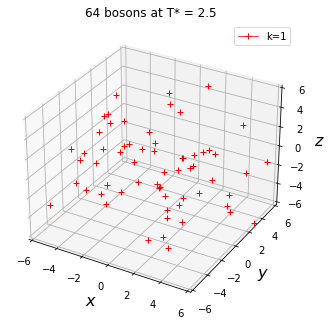

In [17]:
# snippet 3: Analyze cycles, do 3d plot
import pylab, mpl_toolkits.mplot3d

fig = pylab.figure()
ax = mpl_toolkits.mplot3d.axes3d.Axes3D(fig)
#ax.set_aspect('equal')
n_colors = 10
list_colors = pylab.cm.rainbow(numpy.linspace(0, 1, n_colors))[::-1]
dict_colors = {}
i_color = 0
positions_copy = positions.copy()
while positions_copy:
    x, y, z = [], [], []
    starting_boson = list(positions_copy)[0]
    boson_old = starting_boson
    while True:
        x.append(boson_old[0])
        y.append(boson_old[1])
        z.append(boson_old[2])
        boson_new = positions_copy.pop(boson_old)
        if boson_new == starting_boson: break
        else: boson_old = boson_new
    len_cycle = len(x)
    if len_cycle > 2:
        x.append(x[0])
        y.append(y[0])
        z.append(z[0])
    if len_cycle in dict_colors:
        color = dict_colors[len_cycle]
        ax.plot(x, y, z, '+-', c=color, lw=0.75)
    else:
        color = list_colors[i_color]
        i_color = (i_color + 1) % n_colors
        dict_colors[len_cycle] = color
        ax.plot(x, y, z, '+-', c=color, label='k=%i' % len_cycle, lw=0.75)
pylab.title(str(N) + ' bosons at T* = ' + str(T_star))
pylab.legend()
ax.set_xlabel('$x$', fontsize=16)
ax.set_ylabel('$y$', fontsize=16)
ax.set_zlabel('$z$', fontsize=16)
xmax = 6.0
ax.set_xlim3d([-xmax, xmax])
ax.set_ylim3d([-xmax, xmax])
ax.set_zlim3d([-xmax, xmax])
#pylab.savefig('plot_boson_configuration.png')
pylab.show()

**B1 (continued)**

**Question:** Comment: do you observe **any qualitative difference** between the two final configurations at the two temperatures?

**Answers:** Yes, the difference is apparent at T* = 0.7 the bosons are more condensed and lcoalized compared to that at T* = 2.5.



**B2**

Modify the above program, to produce a figure with two histograms and one curve:

- The **first histogram** should give the **normed distribution of x-positions** of particles, and show it between x = -3 and x = 3.

- The **second histogram** (on the same figure) should produce the **normed distribution of x-positions** of those particles **that are on cycles of length larger than cycle_min = 10**.

- The **analytic curve** (on the same figure), namely the **squared ground-state wave function of the harmonic oscillator**, psi0^2 (x) = exp(-x^2)/sqrt(pi)

ATTENTION: In your program, you need **two lists of samples** (one for each histogram). Construct these histograms inside the program of section **B**. The first histogram is made from the x-positions of "boson_a" (see the program), in other words **boson_a[0]**.  A few lines later, you have the line k = len(perm_cycle). The second histogram is again made from the x-positions of "boson_a" (see the program), in other words **boson_a[0], but only if k > cycle_min**. Do this before the perm_cycle = levy_harmonic....() line. 

When producing the histograms, **do not use pylab.hist(.., range=(-3.0, 3.0)) (this would consider only a part of all positions)** but rather:

pylab.hist(...)  # this does the histogram for all positions

pylab.xlim(-3.0, 3.0) # this plots the above histogram in the restricted range -3.0 .... 3.0

Run your program with **cycle_min=10, N=512 and T_star=0.8**.

- Upload the figure with two histograms(make sure this same figure contains the curve of |psi0(x)|^2).

**NB: Use labels and legends to distinguish the three data sets, use the "alpha" keyword in pylab.hist to make the histograms semi-transparent**.

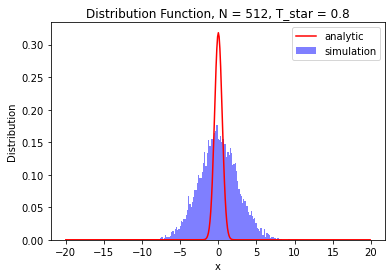

In [105]:
import random, math, numpy, sys, os

def levy_harmonic_path_3d(k):
    x0 = tuple([random.gauss(0.0, 1.0 / math.sqrt(2.0 *
                math.tanh(k * beta / 2.0))) for d in range(3)])
    x = [x0]
    for j in range(1, k):
        Upsilon_1 = 1.0 / math.tanh(beta) + 1.0 / \
                          math.tanh((k - j) * beta)
        Upsilon_2 = [x[j - 1][d] / math.sinh(beta) + x[0][d] /
                     math.sinh((k - j) * beta) for d in range(3)]
        x_mean = [Upsilon_2[d] / Upsilon_1 for d in range(3)]
        sigma = 1.0 / math.sqrt(Upsilon_1)
        dummy = [random.gauss(x_mean[d], sigma) for d in range(3)]
        x.append(tuple(dummy))
    return x

def rho_harm_3d(x, xp):
    Upsilon_1 = sum((x[d] + xp[d]) ** 2 / 4.0 *
                    math.tanh(beta / 2.0) for d in range(3))
    Upsilon_2 = sum((x[d] - xp[d]) ** 2 / 4.0 /
                    math.tanh(beta / 2.0) for d in range(3))
    return math.exp(- Upsilon_1 - Upsilon_2)

N = 512
T_star = 0.8
beta = 1.0 / (T_star * N ** (1.0 / 3.0))

# Initial condition
positions = {}
for k in range(N):
    a = levy_harmonic_path_3d(1)
    positions[a[0]] = a[0]
    
# Monte Carlo loop
nsteps = 10000
First_data = []
for step in range(nsteps):    
    # move 1: resample one permutation cycle
    boson_a = random.choice(list(positions.keys()))
    perm_cycle = []
    while True:
        perm_cycle.append(boson_a)
        boson_b = positions.pop(boson_a)
        if boson_b == perm_cycle[0]:
            break
        else:
            boson_a = boson_b
    First_data.append(boson_a[0])
    
    k = len(perm_cycle)
    #print(boson_a[0])
    #print("cycle", k)
    perm_cycle = levy_harmonic_path_3d(k)
    positions[perm_cycle[-1]] = perm_cycle[0]
    for k in range(len(perm_cycle) - 1):
        positions[perm_cycle[k]] = perm_cycle[k + 1]
    # move 2: exchange
    a_1 = random.choice(list(positions.keys()))
    b_1 = positions.pop(a_1)
    a_2 = random.choice(list(positions.keys()))
    b_2 = positions.pop(a_2)
    weight_new = rho_harm_3d(a_1, b_2) * rho_harm_3d(a_2, b_1)
    weight_old = rho_harm_3d(a_1, b_1) * rho_harm_3d(a_2, b_2)
    if random.uniform(0.0, 1.0) < weight_new / weight_old:
        positions[a_1] = b_2
        positions[a_2] = b_1
    else:
        positions[a_1] = b_1
        positions[a_2] = b_2
#for boson in positions.keys():
   # print(boson, positions[boson])

def groundsate(x):
    psi0_x = (math.exp(-x **2)/(math.sqrt(math.pi)))**2
    return psi0_x

list_x = [0.1 * a for a in range (-200,200)]
list_y = [groundsate(x) for x in list_x]
pylab.plot(list_x, list_y, label='analytic', color = 'red')
pylab.hist(First_data, 120, density = True, stacked = True, label='simulation', fc = [0,0,1, 0.5])
pylab.xlabel('x')
pylab.ylabel('Distribution')
pylab.title('Distribution Function, N = 512, T_star = 0.8')
pylab.legend()
#pylab.xlim(-3,3)
#pylab.savefig('')
pylab.show()    

**B2 (continued)**

**Question** Explain why the two histograms give different results, and explain why one of the histograms can be compared to the squared ground state wave function,  if cycle_min is sufficiently large.

**Answer**


NB:  The main achievement of the the 1995 paper by Cornell and Wieman, et  al, was that that the particle distribution had two components: a peaked  one and a broad one. This is what was shown in the figure in the  introduction. This  is what you identify here in your own data.

NB: Use a nice title, print out the picture on glossy paper and either make yourself a T-shirt or buy yourself a picture frame and hang it up in your room.

